<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [63]:
!python -m pip install rdkit-pypi

In [64]:
!pip install catboost

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem import Descriptors as dscr, Descriptors3D as dscr3D
import rdkit.ML.Descriptors.MoleculeDescriptors as moldscr

from rdkit.Chem.SaltRemover import SaltRemover

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Функции

In [66]:
def get_submission_file(clf, data):
    
    X_test = data[data['is_test']].\
        drop(['is_test', 'smiles', 'active'], axis=1)

    submission = data.loc[data['is_test'], ['smiles']].reset_index(drop=True)
    submission['Active'] = clf.predict(X_test)
    submission.columns = ['Smiles', 'Active']

    submission.to_csv('submission.csv')
    return submission

def remove_salt_ions(smiles):

    sr = SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    result, deleted = sr.StripMolWithDeleted(mol)
    
    result = Chem.MolToSmiles(result)
    deleted = list(map(Chem.MolToSmiles, deleted))

    return result, deleted

def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_ 

def strp_mol(smiles):
    
    s_ = smiles
    to_clear = ['(', ')', '[', ']', '=', '-',
                '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for sym in to_clear:
        s_ = s_.replace(sym, '')
    return s_
    
def gen_2D_descr_features(data, descr_ls):
    data_ = data.copy()
    # data_.columns = list(data_.columns) + descr_ls
    mdc = moldscr.MolecularDescriptorCalculator(descr_ls)
    descr_series = data_['smiles'].apply(
        lambda s: mdc.CalcDescriptors(Chem.MolFromSmiles(s))
        )
    data_[descr_ls] = pd.DataFrame(descr_series.tolist(),
                                   index = data_.index,
                                   )
    return data_

## Загружаем данные:

In [168]:
train_path = 'https://raw.githubusercontent.com/akitim/Ligand_activity_prediction_GlobalAI2022/main/data/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/Ligand_activity_prediction_GlobalAI2022/main/data/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
1236,1236,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,False
3467,3467,CSc1nc2cc(Cl)c(Oc3cccc(Cl)c3Cl)cc2[nH]1,False
3816,3816,CC(C)(C)CC(C)(C)c1ccc(O)c(Cc2ccc(Cl)cc2Cl)c1,False
5471,5471,CN([C@@H](Cc1ccc(OS(=O)(=O)c2cccc3cnccc23)cc1)...,False
3821,3821,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,False


In [169]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = False
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = None #pd.NA().nan
test.columns = ['smiles', 'active']
test['is_test'] = True

data = pd.concat([train, test]).reset_index(drop=True)

In [69]:
data.sample(5)

,smiles,active,is_test
2190,O=C(NO)c1ccccc1O,False,False
2934,COc1ccc(C(C)=O)c(O)c1,False,False
4559,COc1cc([C@@H]2c3cc4c(cc3C(O[C@@H]3O[C@@H]5CO[C...,False,False
4081,CCN1CCCC1=O,False,False
4728,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2c3ccccc3Sc3c...,False,False


In [76]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [77]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Модель 0 (random baseline)

In [11]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Предобработка

In [170]:
# удаляем соли
# deleted_salts = data['smiles'].apply(lambda s: remove_salt_ions(s)[1])
data['smiles'] = data['smiles'].apply(lambda s: remove_salt_ions(s)[0])

double_ind = [1854, 1939, 3187, 6724, 2721]
empty_ind = [530, 2569, 5605, 5632]

data.loc[double_ind, 'smiles'] = \
    data.loc[double_ind, 'smiles'].apply(lambda smls: smls.split('.')[0])

data.loc[empty_ind, 'smiles'] = 'O'

In [171]:
# deleted_salts = deleted_salts[deleted_salts.apply(lambda x: any(x) and any([el != '*' for el in x]))]
# deleted_salts[deleted_salts.apply(lambda x: len(x) > 1)]

# перезагрука данных
data_ = data[['smiles', 'active', 'is_test']].copy()
data = data_.copy()

## Генерация новых признаков

In [165]:
data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.AddHs(
                                      Chem.MolFromSmiles(x))), 1)
                                  )

entities = ['C', 'c', 'ccccc', 'O', 'o', 'N', 'N+', 'n', 'P',
         'S', 's', 'Cl', 'Br', 'F', '(', '/']

for ent in entities:
    data = num_of_(data, ent)

data['MW+(+C+O'] =  data['MW'] + data['('] + data['C'] + data['O']
data = data.drop(['MW', '(', 'C', 'O'], axis=1)

descr_ls = [
            # 'BalabanJ',
            # 'NumHAcceptors',
            'NumHDonors', 
            # 'BertzCT',
            # 'Ipc', 'HallKierAlpha', 'Chi0',
            # 'RingCount',
            # 'NumAromaticRings',
            # 'NumAromaticHeterocycles', 
            'MolLogP']

data = gen_2D_descr_features(data, descr_ls)

# логарифмируем переменнные
# for col in data.drop(['smiles', 'active', 'is_test'], axis=1).columns:
#     data[col] = data[col].apply(np.log1p)

In [107]:
data

,smiles,active,is_test,c,ccccc,o,N,N+,n,P,S,s,Cl,Br,F,/,MW+(+C+O,BalabanJ,NumHDonors,NumAromaticRings,MolLogP
0,COc1ccc2[nH]cc(CCN)c2c1,False,False,2.197225,0.000000,0.000000,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,5.279135,1.257918,1.098612,1.098612,0.984958
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,False,False,1.945910,0.000000,0.000000,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,5.443716,1.110107,0.693147,0.693147,1.381684
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,False,2.708050,0.693147,0.000000,1.386294,0.0,1.098612,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,6.060291,0.904446,1.098612,1.386294,0.815232
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,False,3.178054,0.000000,0.000000,1.098612,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.693147,0.0,6.121396,0.825934,1.098612,1.609438,1.808977
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,False,2.995732,0.693147,0.000000,0.693147,0.0,1.098612,0.0,0.000000,0.0,0.000000,0.0,0.693147,0.0,5.815324,0.897715,1.098612,1.609438,1.733212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7166,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True,1.945910,0.000000,0.000000,1.386294,0.0,0.000000,0.0,1.098612,0.0,0.693147,0.0,0.000000,0.0,6.013471,1.015034,1.386294,0.693147,0.801777
7167,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True,2.484907,0.000000,0.000000,1.386294,0.0,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,5.892749,1.190385,1.386294,1.098612,1.261275
7168,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,6.154008,1.002516,1.098612,0.000000,1.418907
7169,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True,2.833213,0.000000,0.000000,1.098612,0.0,1.098612,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,5.803326,0.990484,1.098612,1.386294,1.565298


In [28]:
corr_matrix = data.drop(['smiles', 'active', 'is_test'], axis=1).corr()
corr_matrix[np.abs(corr_matrix) > 0.5]

,c,ccccc,o,N,N+,n,P,S,s,Cl,Br,F,MW+(+C+O,NumHAcceptors,NumHDonors,RingCount,NumAromaticRings,MolLogP,/
c,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.539967,0.952885,NaN,NaN
ccccc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
o,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N+,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571359,NaN,NaN
P,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Логрегрессия и случайный лес

In [164]:
RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

std_scaler = StandardScaler()
std_scaler.fit(data[~data['is_test']]
               .drop(['is_test', 'smiles', 'active'], axis=1))

X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
X_total.loc[:,:] = std_scaler.transform(X_total)
data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
X = data[~data['is_test']].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[~data['is_test'], 'active'].astype('int32')

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

In [ ]:
RND_SEED = 142

lrgr = LogisticRegression(random_state=RND_SEED,
                          n_jobs=-1, 
                          class_weight='balanced',
                          max_iter=500)
lrgr.fit(X_train, y_train)
y_pred_lrgr = lrgr.predict(X_val)

# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

In [83]:
# оценка при разных сидах ГСЧ
f1_ = []
for rnd in np.random.randint(1, 100000, 10):
    rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=rnd,
                             class_weight='balanced')
    rfc.fit(X_train, y_train)
    y_pred_rfc = rfc.predict(X_val)
    f1_ += [f1_score(y_val, y_pred_rfc)]
np.mean(f1_)

0.18946908552388003

## Submission RFC & LogRegression

In [ ]:
get_submission_file(rfc, data)

## Логрегрессия с кросс-валидацией

In [ ]:
lrgr_cv = LogisticRegressionCV(Cs=10, #np.logspace(-8, 3, endpoint= True),
                               cv=5, # cv=int - Stratified Cross-Validation w/10 folds
                               scoring='f1',
                               solver='liblinear',
                               penalty='l2',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=RND_SEED, 
                            #    l1_ratios=np.arange(0, 1.2, 0.3)
);
lrgr_cv.fit(X, y)


Max F1 = 0.11255935884492427


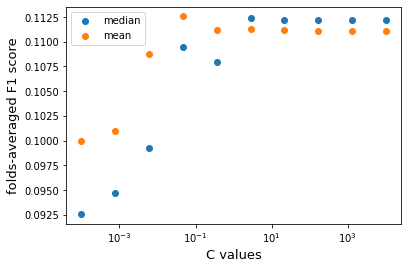

In [22]:
lrgr_cv.scores_[True].shape
lrgr_cv.get_params()

# print(lrgr_cv.Cs_)
# print(lrgr_cv.scores_[True].mean(axis=0))

plt.scatter(lrgr_cv.Cs_, np.median(lrgr_cv.scores_[True], axis=0));
plt.scatter(lrgr_cv.Cs_, np.mean(lrgr_cv.scores_[True], axis=0));
plt.xlabel('C values', fontsize=13)
plt.ylabel('folds-averaged F1 score', fontsize=13)
plt.xscale('log');
plt.legend(['median', 'mean'], loc='best');

print( f'Max F1 = {np.mean(lrgr_cv.scores_[True], axis=0).max()}')

In [20]:
y_p = lrgr_cv.predict(X_val)
f1_score(y_val, y_p)

0.0925925925925926

##Catboost с кросс-валидацией

In [126]:
from catboost import CatBoostClassifier, Pool, FeaturesData

RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

std_scaler = StandardScaler()
std_scaler.fit(data[~data['is_test']]
               .drop(['is_test', 'smiles', 'active'], axis=1))

X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
X_total.loc[:,:] = std_scaler.transform(X_total)
data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
features_to_drop = [
                    'smiles',
                    'is_test', 'active'
]

X_cb = data[~data['is_test']].drop(features_to_drop, axis=1)
y_cb = data.loc[~data['is_test'], 'active']

X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(
    X_cb, y_cb, test_size=0.2, random_state=RND_SEED
)

cb_clf = CatBoostClassifier(
    loss_function=None,
    eval_metric='F1',
    learning_rate=0.5,
    verbose=False,
    # text_processing=text_processing_options,
    random_seed=RND_SEED
)

cb_clf.fit(X_cb_train, y_cb_train.astype(str)
        #    text_features=['smiles']
)
y_pred_cb = cb_clf.predict(X_cb_val)
y_pred_cb = np.asarray([y == 'True' for y in y_pred_cb])

f1_score(y_cb_val.astype('int8'), (y_pred_cb).astype('int8'))

0.28125

In [160]:
get_submission_file(cb_clf, data)

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,False
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,True
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,False
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,False
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,False
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,False


In [162]:
from catboost import cv

train_pool = Pool(
    data=X_cb,
    label=y_cb.astype(str),
    has_header=True
)

params = {
    'loss_function': 'Logloss',
    # 'iterations': 100,
    'custom_loss': 'F1',
    'learning_rate': 0.5,
    'random_state': RND_SEED
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=3,
    shuffle=True,
    partition_random_seed=RND_SEED,
    plot=False,
    stratified=True,
    verbose=False
)


Training on fold [0/3]

bestTest = 0.1438230988
bestIteration = 14

Training on fold [1/3]

bestTest = 0.1531162273
bestIteration = 8

Training on fold [2/3]

bestTest = 0.144804524
bestIteration = 13



---
---
---
ИДЕИ
---
---

### Дескрипторы из RDkit

In [ ]:
smpl_ind = np.random.randint(0, 5556, 1)[0]
smpl = data.loc[smpl_ind, 'smiles']

if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
charge = Chem.MolLogP(mol)
print(f'{smpl_ind}\n{smpl}\n{if_active}\nCharge: {charge}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

In [ ]:
from rdkit.Chem import Descriptors as dscr, Descriptors3D as dscr3D
import rdkit.ML.Descriptors.MoleculeDescriptors as moldscr
from rdkit.Chem import AllChem

# mol = Chem.MolFromSmiles(smpl)
# mol = Chem.AddHs(mol)
# AllChem.EmbedMolecule(mol)
# dscr.(mol)
descr_ls = [
            'BalabanJ',
            'TPSA', 'NHOHCount', 'NumHAcceptors',
            'NumHDonors', 'BertzCT', 'Ipc', 'HallKierAlpha', 'Chi0',
            'RingCount' ,'NumAromaticRings', 'NumAromaticHeterocycles', 
            'MolLogP']
# mdc = moldscr.MolecularDescriptorCalculator(descr_ls)
# mdc.CalcDescriptors(mol)

# mol = Chem.AddHs(mol)
# AllChem.EmbedMolecule(mol)
# dscr3D.RadiusOfGyration(mol)
# dscr3D.rdMolDescriptors.CalcMORSE(mol)
# AllChem.ComputeMolVolume(mol), dscr3D.RadiusOfGyration(mol)
# dscr.MolLogP(mol)

def gen_3D_descr_features(data):
    def prep(smls):
        mol = Chem.AddHs(Chem.MolFromSmiles(smls))
        AllChem.EmbedMolecule(mol)
    return mol

    data_ = data.copy()
    data_['RoG'] = \
        data_['smiles'].apply(lambda s: dscr3D.RadiusOfGyration(prep(s))) 
    data_['Vol'] = \
        data_['smiles'].apply(lambda s: AllChem.ComputeMolVolume(prep(s)))
    return data_

smls_ls = []
def prep(smls):
    # smls_ls += [smls]  
    mol = Chem.AddHs(Chem.MolFromSmiles(smls))
    AllChem.EmbedMolecule(mol)
    return mol

def make_conformer(smls):
    mol = Chem.AddHs(Chem.MolFromSmiles(smls))
    AllChem.EmbedMolecule(mol)
    return mol.GetNumConformers

# data['Vol'] = data['smiles'].apply(lambda s: AllChem.ComputeMolVolume(prep(s)))
# data['RoG'] = data['smiles'].apply(lambda s: dscr3D.RadiusOfGyration(prep(s)))
n_conf = data['smiles'].apply(lambda s: prep(s))

In [178]:
data.smiles[data.smiles.apply(lambda s: '.' in s )]

138           O=C1CCCN1CC#CCN1CCCC1.O=C1CCCN1CC#CCN1CCCC1
241     N[C@@]1(C(=O)O)CC[C@H](C(=O)O)C1.N[C@]1(C(=O)O...
310                  [O-]n1ccccc1=S.[O-]n1ccccc1=S.[Zn+2]
323     Oc1cc(-c2ccccc2)[o+]c2c1ccc1ccccc12.[O-][Cl+3]...
365     CCOC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1C...
                              ...                        
6948    Cc1cc(/C=C/c2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1...
6975    CCOc1cc(N)c(Cl)cc1C(=O)NCC1CN(Cc2ccc(F)cc2)CCO...
7019    Brc1cc2c(cc1[C@@H]1Nc3ccccc3[C@@H]3C=CC[C@@H]3...
7024                         CCNCC.O=S(=O)(O)c1cc(O)ccc1O
7130    N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1.O=S(=O...
Name: smiles, Length: 99, dtype: object

In [158]:
m = Chem.MolFromSmiles('CCCC(CCCC)CCCC(CCCCC)C1ccccC1')
m = Chem.AddHs(m)
AllChem.EmbedMolecule(m)
m.GetNumConformers()


1

### Визуализация молекулы

In [ ]:
# 616                        O1[As]2O[As]3O[As]1O[As](O2)O3
# 1144                                        O=N[O-].[Na+]
# 1172    O=[Mg].O=[Mg].O=[Mg].O=[Si]=O.O=[Si]=O.O=[Si]=...
# 2569                                            [I-].[K+]
# 2858                         O=P([O-])([O-])F.[Na+].[Na+]
# 6264                                          NS(N)(=O)=O

# 616          O1[As]2O[As]3O[As]1O[As](O2)O3
# 915          CC(=O)Nc1cc([As](=O)(O)O)ccc1O
# 5864     O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
# 6562    O=[N+]([O-])c1cc([As](=O)(O)O)ccc1O
# 6761                Nc1ccc([As](=O)(O)O)cc1

N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1.O=S(=O)(O)CCO.O=S(=O)(O)CCO
Unknown


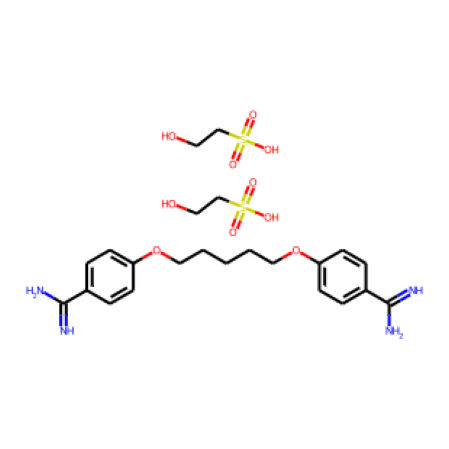

In [177]:
# smpl = train['smiles'][134]
smpl_ind = 7130
smpl = data.loc[smpl_ind, 'smiles']

# smpl = 'C(-c6cnc7ccccc7c6)'
if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}\n{if_active}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

In [62]:
bj = data['BalabanJ']
ind_ = bj[(bj == -666) | (bj == 0)].index
ind_
bj[(bj == -666) | (bj == 0)]

530    -666.0
1854      0.0
1939      0.0
2569   -666.0
2721      0.0
3187      0.0
5605   -666.0
5632   -666.0
6724      0.0
Name: BalabanJ, dtype: float64

### Визуализируем группу молекул:

138) O=C1CCCN1CC#CCN1CCCC1.O=C1CCCN1CC#CCN1CCCC1 Not active
241) N[C@@]1(C(=O)O)CC[C@H](C(=O)O)C1.N[C@]1(C(=O)O)CC[C@@H](C(=O)O)C1 Not active
310) [O-]n1ccccc1=S.[O-]n1ccccc1=S.[Zn+2] Active
323) Oc1cc(-c2ccccc2)[o+]c2c1ccc1ccccc12.[O-][Cl+3]([O-])([O-])[O-] Not active
365) CCOC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1Cl.O=S(=O)(O)c1ccccc1 Not active
398) COc1ccc(CC(C)NCC(O)c2ccc(O)c(NC=O)c2)cc1.COc1ccc(CC(C)NCC(O)c2ccc(O)c(NC=O)c2)cc1 Not active
410) CCN(CC)CCc1nc(-c2ccccc2)no1.O=C(O)CC(O)(CC(=O)O)C(=O)O Not active
602) CO[C@@H]1COCC[C@@H]1N[C@@H]1CC[C@@](C(=O)N2CCc3ncc(C(F)(F)F)cc3C2)(C(C)C)C1.O=C(O)CCC(=O)O Not active
676) O=C(O)CCC(=O)O.O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1 Not active
679) O=C(O)C(c1ccccc1)(c1ccccc1)c1ccccc1.OCc1cc([C@@H](O)CNCCCCCCOCCOCc2c(Cl)cccc2Cl)ccc1O Not active
727) O=C(O)c1ccc2ccccc2c1O.OCc1cc(C(O)CNCCCCCCOCCCCc2ccccc2)ccc1O Not active
828) C[N+](C)(CCOc1ccccc1)Cc1ccccc1.O=C([O-])c1ccc2ccccc2c1O Not active
863) CCCCCCCN(CC)CCCC(O)c1ccc(NS(C)(=O)

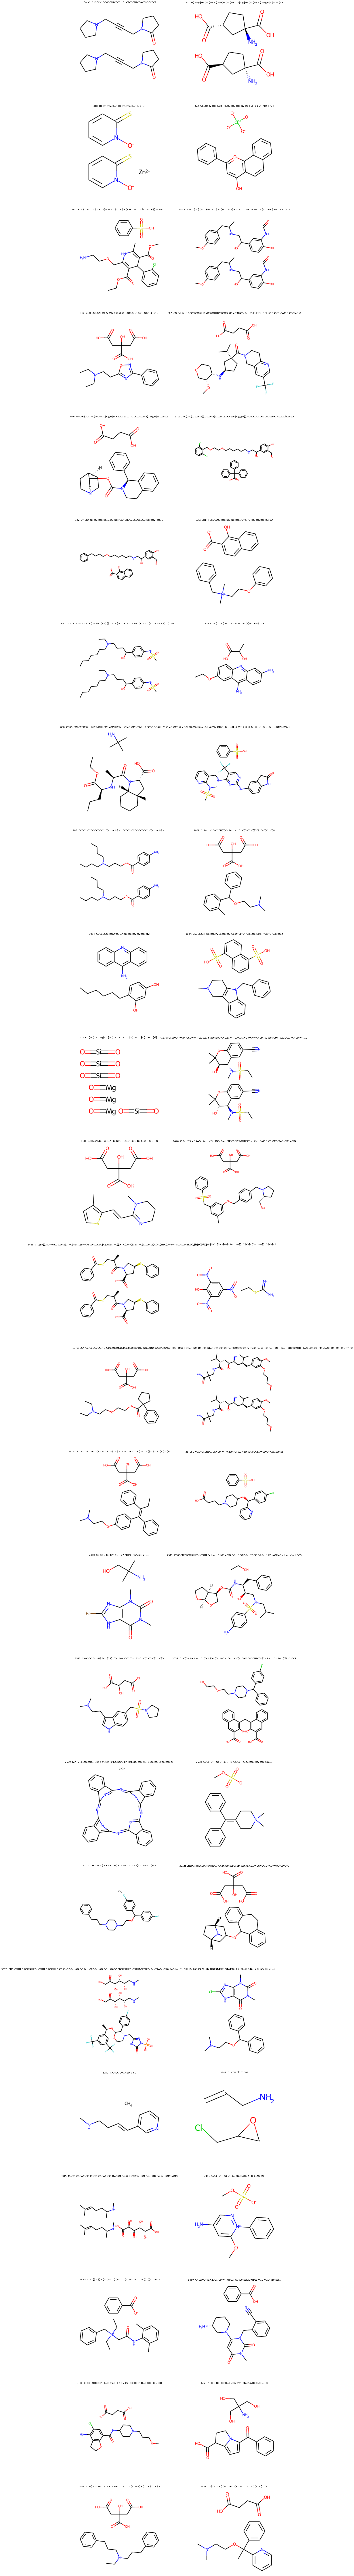

In [184]:
# samples = train.iloc[active_ind, :]['smiles'].values
start_n = 0
stop_n = 50
n_to_plot = stop_n - start_n
n_plot_rows = n_to_plot // 2 + n_to_plot % 2
# mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.']))
samples = data.loc[data['smiles'].apply(lambda s: '.' in s ), ['smiles']][start_n:stop_n]

# samples = pd.DataFrame(deleted_salts[start_n:stop_n])

fig, axs = plt.subplots(n_plot_rows, 2, figsize=(20, n_to_plot*5))
axs = (ax for ax in axs.ravel())

for ind in samples.index:

    if_active = 'Active' if data.loc[ind, 'active'] \
                    else ('Not active' if ind < 5556 else 'Unknown')

    ax_curr = next(axs)
    smpl = samples.loc[ind, 'smiles']
    mol = Chem.MolFromSmiles(smpl)
    im = Chem.Draw.MolToImage(mol)
    print(f'{ind}) {smpl} {if_active}')
    # plt.figure(figsize = (3, 3))
    # axs(i) = plt.axes(frameon=True)
    ax_curr.imshow(im)
    ax_curr.set_title(f'{ind}: {smpl}');
    ax_curr.axis('off');

# # удаляем пустой график
# if n_to_plot % 2:
#     ax_curr = next(axs)
#     im = Chem.Draw.MolToImage(Chem.MolFromSmiles('C1CCC1'))
#     ax_curr.imshow(im)
#     fig.delaxes(ax_curr)    
# for ax in axs:    
#     if not(ax.has_data()):
#         fig.delaxes(ax_curr)

In [ ]:
# 530) 
# 1854) CCCCCC(C)N.CCCCCC(C)N
# 1939) CC(=O)NCCCS(=O)(=O)[O-].CC(=O)NCCCS(=O)(=O)[O-]
# 2569) 
# 2721) N#Cc1c(N(CC(=O)[O-])CC(=O)[O-])sc(C(=O)[O-])c1CC(=O)[O-].[Sr+2].[Sr+2]
# 3187) O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
# 5605) 
# 5632) 
# 6724) CC(C)(O)CC(=O)O.CC(C)(O)CC(=O)O



In [ ]:
# (data.loc[smpl_ind, 'active'])
mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))
samples = data.loc[mask_, 'smiles']
samples.iloc[68]

'CCOC(=O)OC(C)OC(=O)[C@@H]1N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1(C)C.Cl'

In [ ]:
from rdkit.Chem.SaltRemover import SaltRemover

remover = SaltRemover()
mol = Chem.MolFromSmiles('F.C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.O=[N+]([O-])[O-].O=C(O)C(=O)O')
res, deleted = remover.StripMolWithDeleted(mol)
# Chem.MolToSmiles(delete[1]), Chem.MolToSmiles(res.])
Chem.MolToSmiles(res)
# deleted[0]

'C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.F'

### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [ ]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);

In [ ]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');